In [1]:
import torch
from control_stork.optimizers import SMORMS3
from control_stork.nodes import LIFGroup, FastLIFGroup, NoisyFastLIFGroup
from control_stork.nodes import InputGroup, ReadoutGroup, FastReadoutGroup, DirectReadoutGroup, TimeAverageReadoutGroup
from control_stork.connections import Connection, BottleneckLinearConnection
from control_stork.models import RecurrentSpikingModel
from control_stork.initializers import FluctuationDrivenCenteredNormalInitializer, KaimingNormalInitializer, DistInitializer, AverageInitializer
from control_stork.monitors import SpikeMonitor, SpikeCountMonitor, StateMonitor, PopulationFiringRateMonitor, PopulationSpikeCountMonitor
from control_stork.regularizers import LowerBoundL2, UpperBoundL2
from control_stork.activations import SigmoidSpike
from control_stork.layers import Layer

import time
import math
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device', device)

#torch.autograd.set_detect_anomaly(True)

using device cuda


In [3]:
# Another to plot any continuous variable over time.
def plot_spikes(spk: torch.Tensor, dim: tuple = (3, 5), title='') -> None:
    fig = plt.figure(figsize=(10, 4))
    gs = plt.GridSpec(*dim, figure=fig)
    if title:
        fig.suptitle(title)
    for i in range(math.prod(dim)):
        if i==0:
            a0=ax=plt.subplot(gs[i])
        else:
            ax=plt.subplot(gs[i],sharey=a0)
        #ax.axis("off")
        ax.imshow(spk[i].T, cmap=plt.cm.gray_r, aspect="auto", interpolation='none')
        ax.spines[['right', 'top']].set_visible(False)
        if i == (dim[0] - 1) * dim[1]:
            ax.axis("on")
            ax.set_ylabel("Neuron Number")
            ax.set_xlabel('Time Step')
        else:
            ax.xaxis.set_tick_params(labelbottom=False)
            ax.yaxis.set_tick_params(labelleft=False)

In [4]:
# Another to plot any continuous variable over time.
def plot_traces(trace: torch.Tensor, spk: torch.Tensor = None, dim: tuple = (3,5),
                spike_height: float = 10, ylabel: str = 'V(t)', title: str = '') -> None:
    fig = plt.figure(figsize=(10, 4))
    if title:
        fig.suptitle(title)
    gs = plt.GridSpec(*dim, figure=fig)
    if spk is not None:
        dat = 1.0*trace
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = trace.detach().cpu().numpy()
    for i in range(math.prod(dim)):
        if i==0:
            a0=ax=plt.subplot(gs[i])
        else:
            ax=plt.subplot(gs[i], sharey=a0)
        ax.axis("off")
        ax.plot(dat[i], alpha=0.6)
        if i == (dim[0] - 1) * dim[1]:
            ax.axis("on")
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylabel(ylabel)
            ax.set_xlabel('time step')

In [5]:
# model size
n_hidden = 2
input_dim = 2
hidden_dim = 256
output_dim = input_dim
feedback = False

# neuron parameters
neuron_class = FastLIFGroup # NoisyFastLIFGroup  # FastLIFGroup
neuron_kwargs = dict(
    tau_mem = 5e-3,   # BEST WAS 10e-3
    tau_syn = 2e-3,   # BEST WAS 5e-3
    activation = SigmoidSpike,
) #'noise_std': 0.05}
connection_class = BottleneckLinearConnection  # Connection
recurrent = True
connection_kwargs = dict(
    bias = True,
    n_dims = 10,
)

# readout parameters
readout_class = FastReadoutGroup
readout_kwargs = dict(
    n_readouts = 100,
    tau_mem_out = 0.005,
    tau_syn_out = 0.002,)

# initialize weights
sigma_u = 1.0
nu = 15   # ! Check this parameter again
time_step = 2e-3

# optimizer parameters
lr = 5e-4
optimizer_class = SMORMS3 # torch.optim.Adam # SMORMS3

# regularization parameters
lowerBoundL2Strength = 0.
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0. #0.1
upperBoundL2Threshold = 4       # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time


# make the model
rsm = RecurrentSpikingModel(
    device='cpu',
)

# make the initializers
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u,
    nu=nu,
    time_step=time_step,
)

# make the regularizers
regs = []
if lowerBoundL2Strength > 0:
    regLB = LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
    regs.append(regLB)
if upperBoundL2Strength > 0:
    regUB = UpperBoundL2(upperBoundL2Strength,threshold=upperBoundL2Threshold, dims=1)
    regs.append(regUB)
neuron_kwargs['store_sequences'] = ['out'] if regs else []

# make the groups and connections
input_group = prev = rsm.add_group(InputGroup(input_dim, name='Input Group'))
for i in range(n_hidden):
    new = Layer(
        name=f'Hidden Cell Group {i+1}',
        model=rsm,
        size=hidden_dim,
        input_group=prev,
        recurrent=recurrent,
        regs = regs,
        connection_class=connection_class,
        neuron_class=neuron_class,
        neuron_kwargs=neuron_kwargs,
        connection_kwargs=connection_kwargs
    )
    initializer.initialize(new)
    prev = new.output_group

output_layer = new = Layer(
    name='Readout Pool Layer',
    model=rsm,
    size=output_dim * readout_kwargs['n_readouts'],
    input_group=prev,
    recurrent=False,
    regs=regs,
    connection_class=connection_class,
    neuron_class=readout_class,
    neuron_kwargs=neuron_kwargs,
    connection_kwargs=connection_kwargs
)
initializer.initialize(new)
prev = new.output_group

readout_initializer = AverageInitializer()
output_group = new = rsm.add_group(TimeAverageReadoutGroup(
    output_dim,
    steps=5,
    name='Average Readout Group'))
con = rsm.add_connection(Connection(prev, new, bias=False, requires_grad=False))
con.init_parameters(readout_initializer)

if feedback:
    feedback_con = rsm.add_connection(Connection(new, rsm.groups[1], bias=False))
    feedback_con.init_parameters(initializer=initializer)

# make the monitors
for i in range(n_hidden):
    #rsm.add_monitor(PopulationSpikeCountMonitor(rsm.groups[1+i], per_example=True))
    rsm.add_monitor(SpikeCountMonitor(rsm.groups[1+i]))
    rsm.add_monitor(StateMonitor(rsm.groups[1+i], 'out'))
rsm.add_monitor(StateMonitor(rsm.groups[-2], 'out'))
rsm.add_monitor(StateMonitor(rsm.groups[-1], 'out'))

rsm.configure(
    input_group,
    output_group,
    optimizer=optimizer_class,
    optimizer_kwargs={'lr': lr},
    time_step=time_step,
)


for param in rsm.parameters():
    print(param.device) 

rsm.to(device)
rsm.summary()

for param in rsm.parameters():
    print(param.device) 

cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu
cpu

# Model summary

## Groups
Input Group, (2,)
Hidden Cell Group 1, (256,)
Hidden Cell Group 2, (256,)
Readout Pool Layer, (200,)
Average Readout Group, (2,)

## Connections
BottleneckLinearConnection(
  (src): InputGroup() Input Group
  (dst): FastLIFGroup() Hidden Cell Group 1
  (pre_op): Linear(in_features=2, out_features=10, bias=True)
  (op): Linear(in_features=10, out_features=256, bias=True)
) 
BottleneckLinearConnection(
  (src): FastLIFGroup() Hidden Cell Group 1
  (dst): FastLIFGroup() Hidden Cell Group 1
  (pre_op): Linear(in_features=256, out_features=10, bias=True)
  (op): Linear(in_features=10, out_features=256, bias=True)
) 
BottleneckLinearConnection(
  (src): FastLIFGroup() Hidden Cell Group 1
  (dst): FastLIFGroup() Hidden Cell Group 2
  (pre_op): Linear(in_features=256, out_features=10, bias=True)
  (op): Linear(in_features=10, out_features=256, bias=True)
) 
BottleneckLinearConnection

In [6]:
# data parameters
T_warmup = 20
T_data = 480
T = T_warmup + T_data
sec = T * time_step
print(f'Data to process is equivalent to {sec} seconds with dt = {time_step} seconds')
N = 128

data = (torch.rand(N, 1, input_dim) - 0.5) * 2
data = data.repeat(1, T, 1)
data = data.to(device)
target = data.clone()[:, :-T_warmup]

# test the model
with torch.no_grad():
    start = time.time()
    rsm.reset_state(N)
    y = rsm(data, record=True)
    end = time.time()
    print(f'Forward pass took {end-start:.4f} seconds')
    task_loss = torch.mean((y[:, T_warmup:] - target)**2)
    reg_loss = rsm.compute_regularizer_losses()
    total_loss = task_loss + reg_loss

print(f'Task Loss: {task_loss.item():.4f} - Reg Loss: {reg_loss.item():.4f} - Total Loss: {total_loss.item():.4f}')

Data to process is equivalent to 1.0 seconds with dt = 0.002 seconds
Forward pass took 1.1541 seconds
Task Loss: 0.3207 - Reg Loss: 0.0000 - Total Loss: 0.3207



Monitor 1 of type SpikeCountMonitor on Hidden Cell Group 1
torch.Size([128, 256])
Average spikes per second: 195.047

Monitor 2 of type StateMonitor on Hidden Cell Group 1
torch.Size([128, 500, 256])

Monitor 3 of type SpikeCountMonitor on Hidden Cell Group 2
torch.Size([128, 256])
Average spikes per second: 163.193

Monitor 4 of type StateMonitor on Hidden Cell Group 2
torch.Size([128, 500, 256])

Monitor 5 of type StateMonitor on Readout Pool Layer
torch.Size([128, 500, 200])

Monitor 6 of type StateMonitor on Average Readout Group
torch.Size([128, 500, 2])


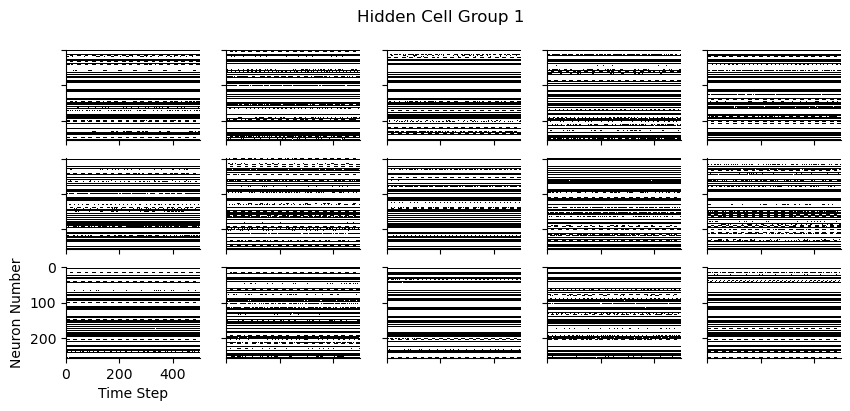

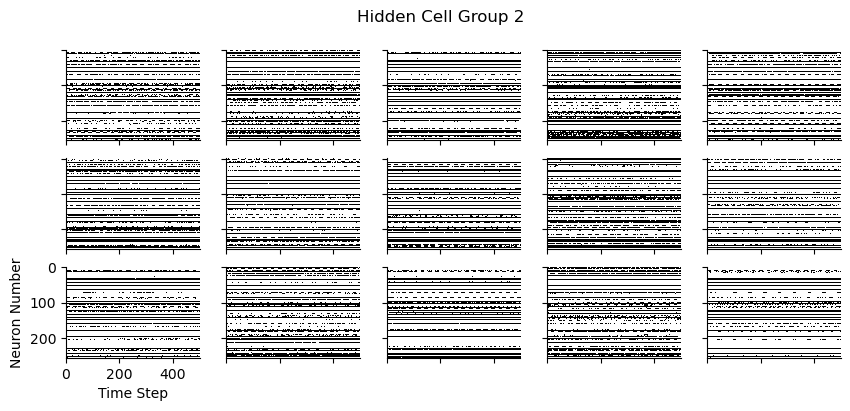

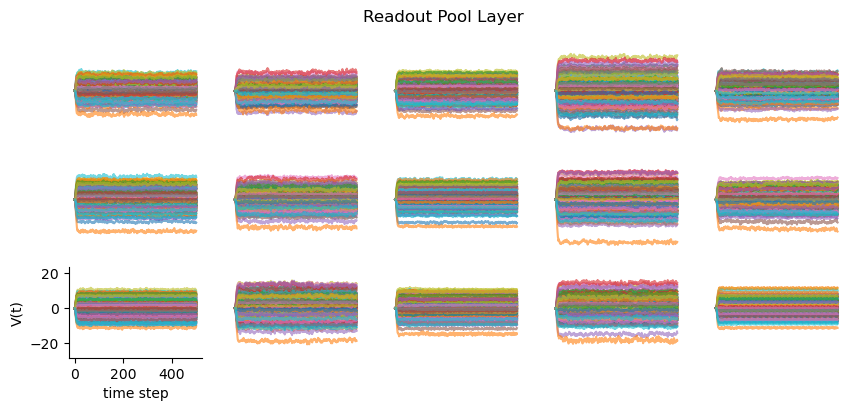

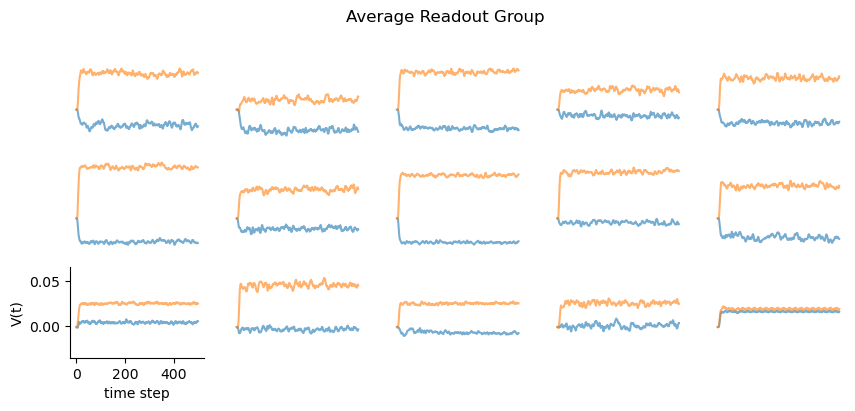

In [7]:
for i, m in enumerate(rsm.monitors):
    print()
    m_type = m.__class__.__name__
    m_group = m.group.name
    print(f"Monitor {i+1} of type {m_type} on {m_group}")
    print(m.get_data().shape)
    #print(m.get_data() / sec)
    #print(torch.mean(m.get_data()))
    #print(torch.count_nonzero(m.get_data()) / torch.numel(m.get_data()))
    #print(m.get_data())
    if m_type == 'SpikeCountMonitor':
        print(f'Average spikes per second: {torch.mean(m.get_data() / sec).item():.3f}')
        #print(f'Number of active neurons:')
        #print(torch.count_nonzero(m.get_data(), dim=0))
        #for i in range(5):
        #    print(m.get_data()[i])
    if m_type == 'StateMonitor':
        if 'Hidden' in m_group:
            plot_spikes(m.get_data(), title=f'{m_group}')
        elif 'Readout' in m_group:
            plot_traces(m.get_data(), title=f'{m_group}')


tensor([0.0707, 0.0707])


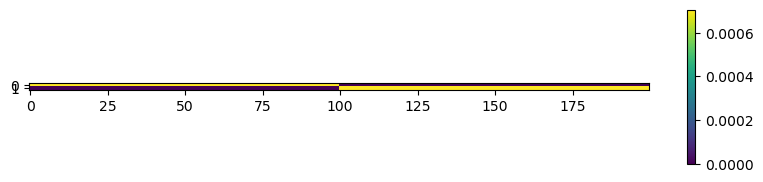

In [8]:
w = rsm.connections[-1].op.weight.detach().cpu()
print(w.sum(1))
fig = plt.figure(figsize=(10, 2))
plt.imshow(w)
plt.colorbar()
plt.show()

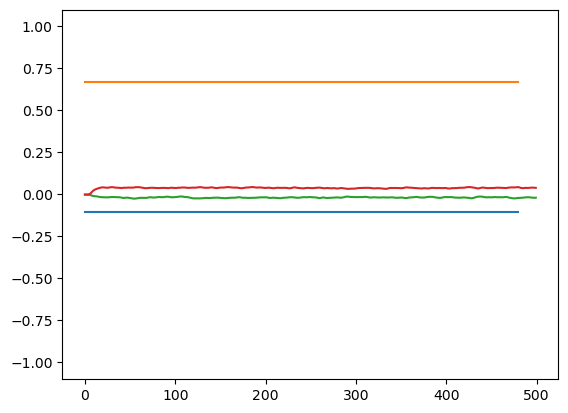

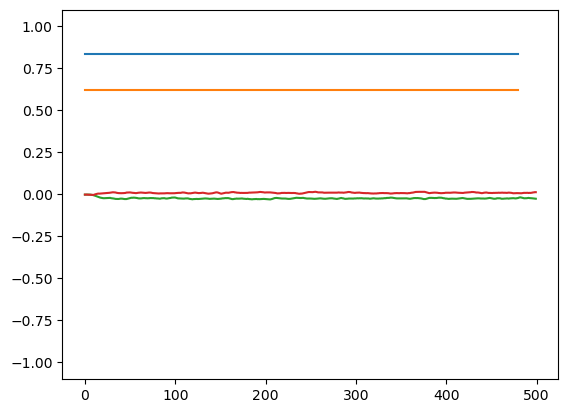

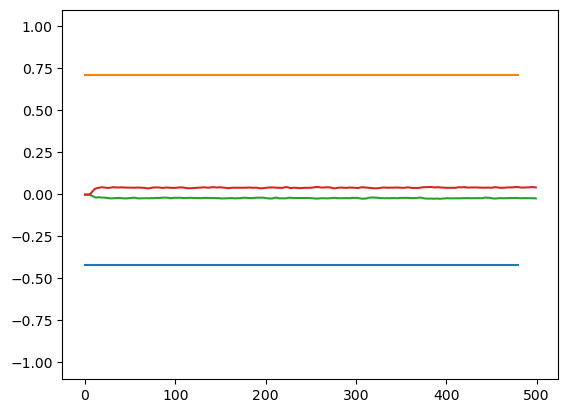

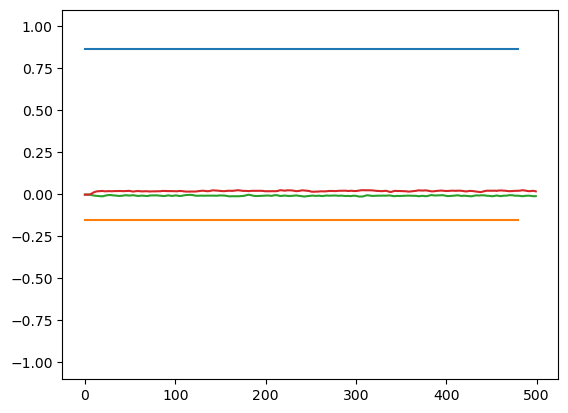

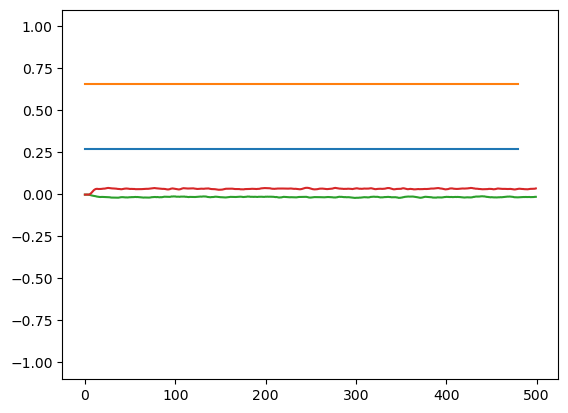

In [9]:
for i in range(5):
    plt.plot(target[i].cpu())
    plt.plot(y[i].detach().cpu())
    plt.ylim(-1.1, 1.1)
    plt.show()

Epoch 1/1000 - Task Loss: 0.33850 - Reg Loss: 0.00000 - Total Loss: 0.33850
Epoch 101/1000 - Task Loss: 0.00402 - Reg Loss: 0.00000 - Total Loss: 0.00402
Epoch 201/1000 - Task Loss: 0.00071 - Reg Loss: 0.00000 - Total Loss: 0.00071
Epoch 301/1000 - Task Loss: 0.00057 - Reg Loss: 0.00000 - Total Loss: 0.00057
Epoch 401/1000 - Task Loss: 0.00033 - Reg Loss: 0.00000 - Total Loss: 0.00033
Epoch 501/1000 - Task Loss: 0.00021 - Reg Loss: 0.00000 - Total Loss: 0.00021
Epoch 601/1000 - Task Loss: 0.00018 - Reg Loss: 0.00000 - Total Loss: 0.00018
Epoch 701/1000 - Task Loss: 0.00016 - Reg Loss: 0.00000 - Total Loss: 0.00016
Epoch 801/1000 - Task Loss: 0.00013 - Reg Loss: 0.00000 - Total Loss: 0.00013
Epoch 901/1000 - Task Loss: 0.00014 - Reg Loss: 0.00000 - Total Loss: 0.00014
Epoch 1000/1000 - Task Loss: 0.00013 - Reg Loss: 0.00000 - Total Loss: 0.00013


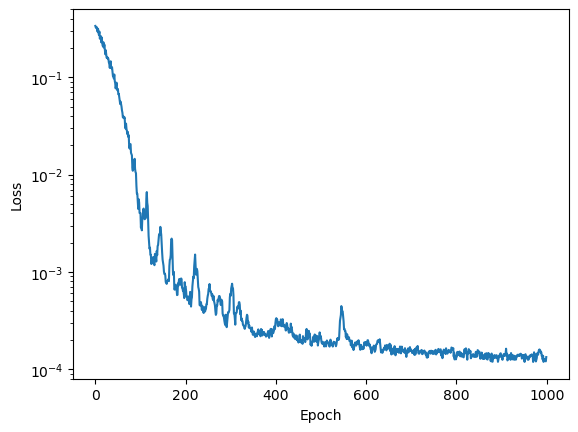

In [10]:
# data parameters
T_warmup = 20
T_data = 80
T = T_warmup + T_data
sec = T * time_step
N = 256

# training parameters
epochs = 1000

losses = []

for e in range(epochs):

    data = (torch.rand(N, 1, input_dim) - 0.5) * 2
    data = data.repeat(1, T, 1)
    data = data.to(device)
    target = data.clone()[:, :-T_warmup]

    rsm.reset_state(N)
    y = rsm(data, record=True)
    task_loss = torch.mean((y[:, T_warmup:] - target)**2)
    reg_loss = rsm.compute_regularizer_losses()
    total_loss = task_loss + reg_loss
    rsm.optimizer_instance.zero_grad()
    total_loss.backward()
    rsm.optimizer_instance.step()

    losses.append([total_loss.item()])
    if e % 100 == 0 or e == epochs-1:
        print(f'Epoch {e+1}/{epochs} - Task Loss: {task_loss.item():.5f} - Reg Loss: {reg_loss.item():.5f} - Total Loss: {total_loss.item():.5f}')

plt.plot(losses)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

tensor([-0.6237, -0.1249])
tensor([-0.6264, -0.1183])


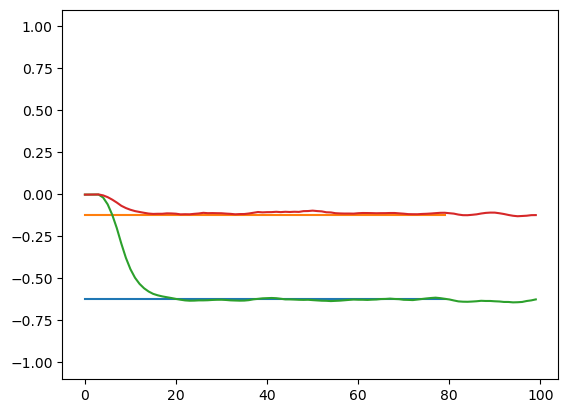

tensor([0.0251, 0.7378])
tensor([0.0262, 0.7439])


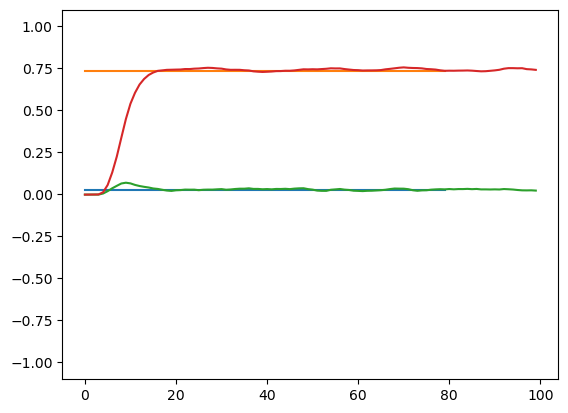

tensor([-0.4345, -0.4450])
tensor([-0.4293, -0.4381])


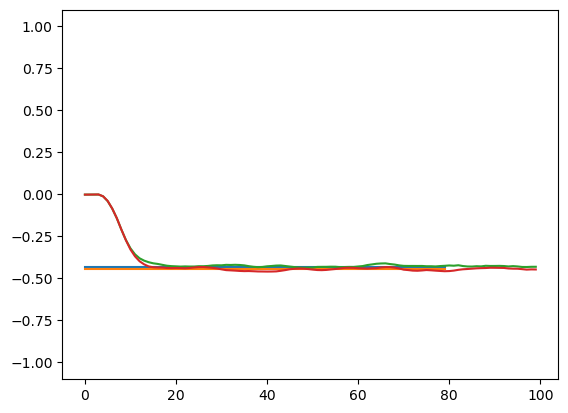

tensor([0.5693, 0.7742])
tensor([0.5651, 0.8094])


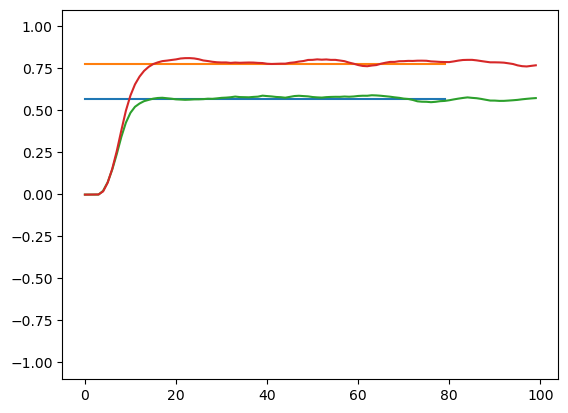

tensor([-0.5839, -0.9724])
tensor([-0.5922, -0.9732])


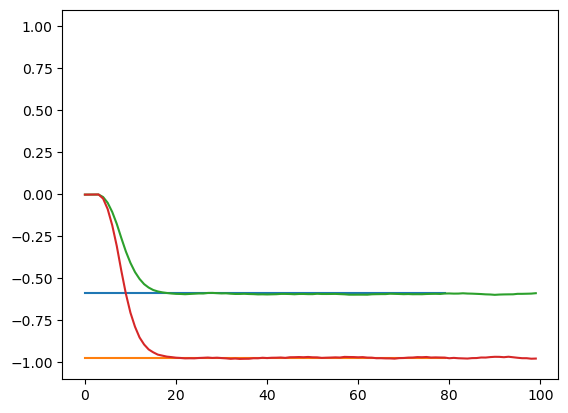

tensor([-0.4618,  0.6510])
tensor([-0.4447,  0.6519])


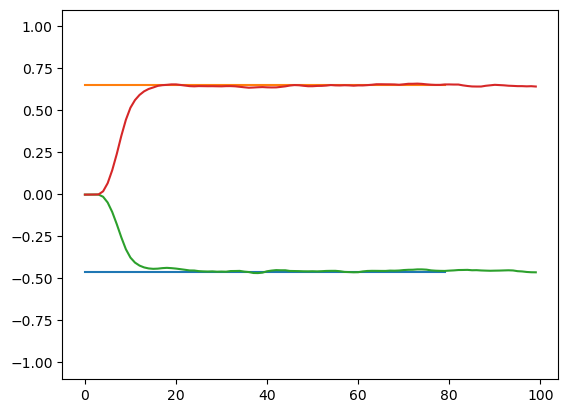

tensor([-0.0344, -0.2883])
tensor([-0.0235, -0.2935])


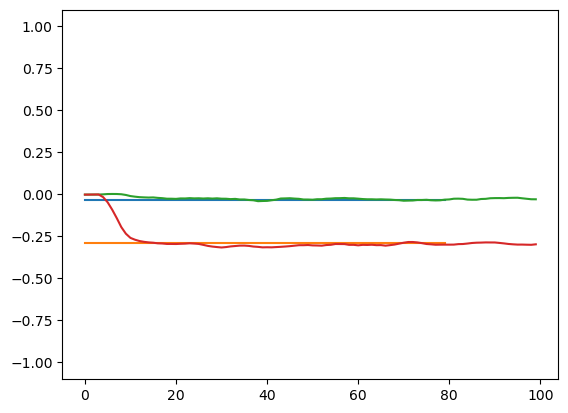

tensor([-0.7453, -0.2728])
tensor([-0.7534, -0.2735])


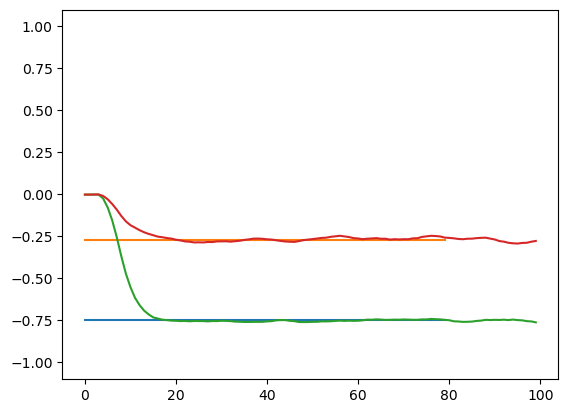

tensor([0.1397, 0.2337])
tensor([0.1273, 0.2394])


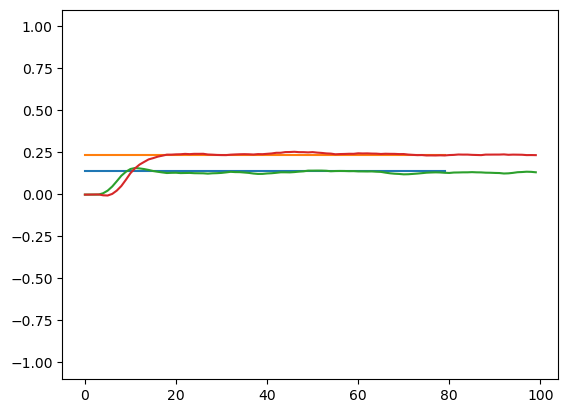

tensor([ 0.5478, -0.2508])
tensor([ 0.5565, -0.2544])


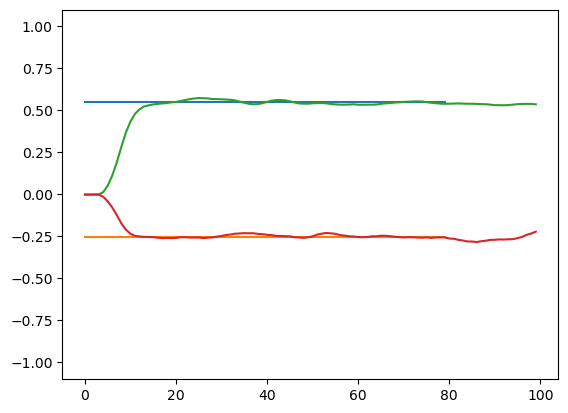

In [11]:
for i in range(10):
    print(target.cpu()[i][0])
    #print(y.detach().cpu()[i][T_warmup+10:T_warmup+15].mean(0))
    print(y.detach().cpu()[i][T_warmup+1])
    plt.plot(target[i].cpu())
    plt.plot(y[i].detach().cpu())
    plt.ylim(-1.1, 1.1)
    plt.show()

tensor([0.0707, 0.0707])


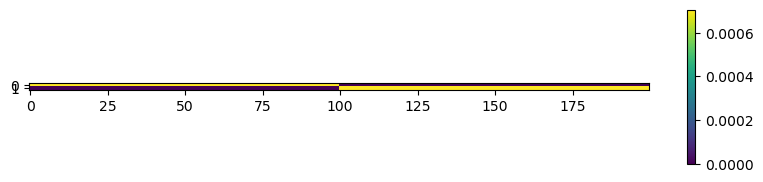

In [12]:
w = rsm.connections[-1].op.weight.detach().cpu()
print(w.sum(1))
fig = plt.figure(figsize=(10, 2))
plt.imshow(w)
plt.colorbar()
plt.show()

Monitor 1 of type SpikeCountMonitor on Hidden Cell Group 1
torch.Size([256, 256])
Average spikes per second: 199.093
Monitor 2 of type StateMonitor on Hidden Cell Group 1
torch.Size([256, 100, 256])
Monitor 3 of type SpikeCountMonitor on Hidden Cell Group 2
torch.Size([256, 256])
Average spikes per second: 197.621
Monitor 4 of type StateMonitor on Hidden Cell Group 2
torch.Size([256, 100, 256])
Monitor 5 of type StateMonitor on Readout Pool Layer
torch.Size([256, 100, 200])
Monitor 6 of type StateMonitor on Average Readout Group
torch.Size([256, 100, 2])


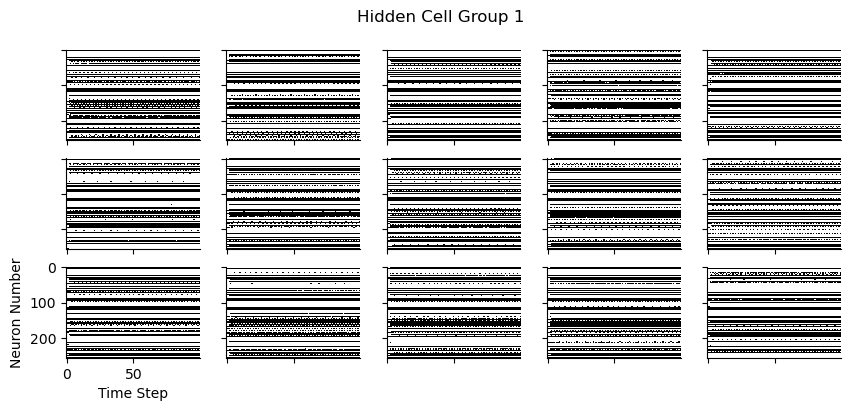

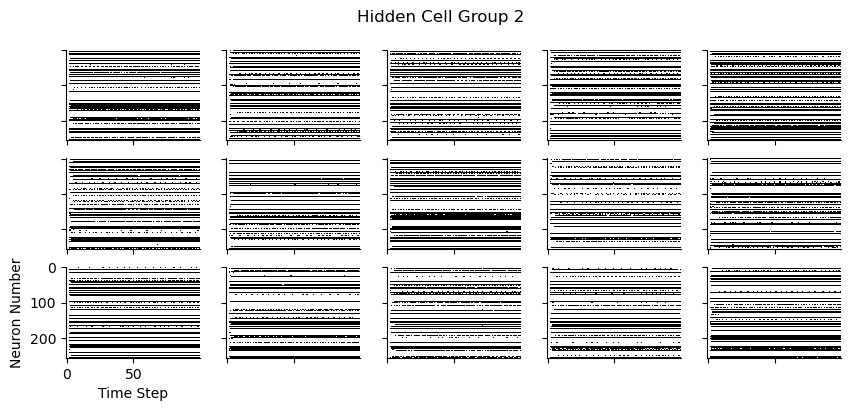

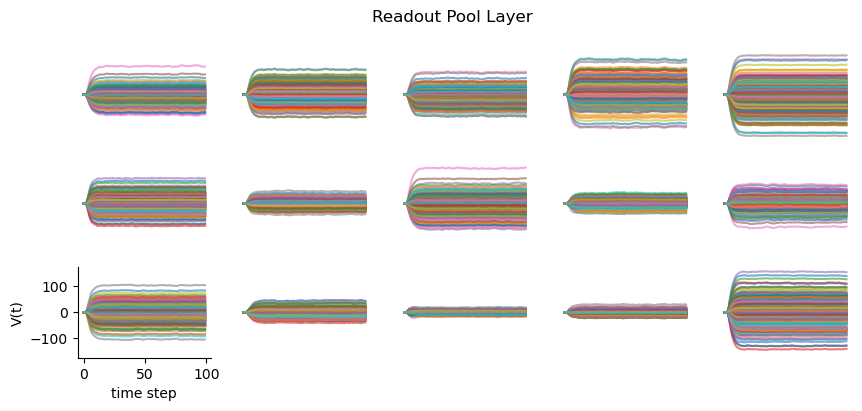

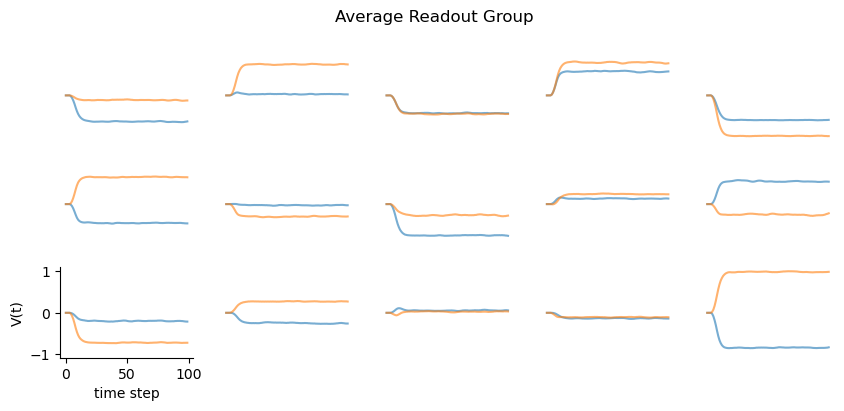

In [13]:
for i, m in enumerate(rsm.monitors):
    m_type = m.__class__.__name__
    m_group = m.group.name
    print(f"Monitor {i+1} of type {m_type} on {m_group}")
    print(m.get_data().shape)
    #print(m.get_data() / sec)
    #print(torch.mean(m.get_data()))
    #print(torch.count_nonzero(m.get_data()) / torch.numel(m.get_data()))
    #print(m.get_data())
    if m_type == 'SpikeCountMonitor':
        print(f'Average spikes per second: {torch.mean(m.get_data() / sec).item():.3f}')
        #print(f'Number of active neurons:')
        #print(torch.count_nonzero(m.get_data(), dim=0))
        #for i in range(5):
        #    print(m.get_data()[i])
    if m_type == 'StateMonitor':
        if 'Hidden' in m_group:
            plot_spikes(m.get_data(), title=f'{m_group}')
        elif 'Readout' in m_group:
            plot_traces(m.get_data(), title=f'{m_group}')